In [1]:
import tensorflow as tf
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt
from tensorflow.keras import layers, models
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing import image
import cv2

In [2]:
IMAGE_SIZE = 256
BATCH_SIZE = 32
CHANNELS=3
EPOCHS = 10

In [3]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "TrainDataset",
    seed=123,
    shuffle = True,
    image_size = (IMAGE_SIZE,IMAGE_SIZE),
    batch_size = BATCH_SIZE
)

Found 2912 files belonging to 2 classes.


In [4]:
class_names = dataset.class_names
class_names

['Fake', 'Real']

In [5]:
len(dataset)

91

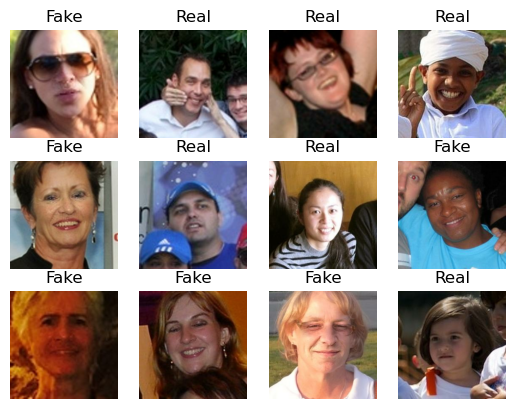

In [6]:
for image_batch, label_batch in dataset.take(1):
    for i in range(12):
        ax = plt.subplot(3,4,i+1)
        plt.title(class_names[label_batch[i]])
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.axis("off")

In [7]:
def get_dataset_partitions_tf(ds, train_split=0.8, val_split=0.1, test_split=0.1, shuffle=True, shuffle_size=10000 ):
    assert (train_split + test_split + val_split) == 1
    
    ds_size = len(ds)
    
    if shuffle:
        ds = ds.shuffle(shuffle_size, seed=12)
    
    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)

    train_ds = ds.take(train_size)
    
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)

    
    return train_ds, val_ds, test_ds

In [8]:
train_ds, val_ds, test_ds = get_dataset_partitions_tf(dataset)

In [9]:
len(train_ds)

72

In [10]:
len(val_ds)

9

In [11]:
len(test_ds)

10

In [12]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

In [13]:
resize_and_rescale = tf.keras.Sequential([
    tf.keras.layers.Resizing(IMAGE_SIZE, IMAGE_SIZE),
    tf.keras.layers.Rescaling(1.0/255)
])

In [14]:
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip("horizontal_and_vertical"),
    tf.keras.layers.RandomRotation(0.2),
])

In [15]:
input_shape = (IMAGE_SIZE, IMAGE_SIZE, CHANNELS)  # Az Input réteg miatt itt nem kell BATCH_SIZE
n_classes = 2

model = models.Sequential([
    layers.Input(shape=input_shape),  # Az input alak itt van megadva
    resize_and_rescale,
    layers.Conv2D(32, kernel_size=(3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, kernel_size=(3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, kernel_size=(3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, kernel_size=(3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, kernel_size=(3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, kernel_size=(3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(n_classes, activation='softmax'),
])


In [16]:
model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ sequential (Sequential)              │ (None, 256, 256, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d (Conv2D)                      │ (None, 254, 254, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 127, 127, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 125, 125, 64)        │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 62, 62, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 60, 60, 64)          │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 30, 30, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 28, 28, 64)          │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 14, 14, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (None, 12, 12, 64)          │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_4 (MaxPooling2D)       │ (None, 6, 6, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_5 (Conv2D)                    │ (None, 4, 4, 64)            │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_5 (MaxPooling2D)       │ (None, 2, 2, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 64)                  │          16,448 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 2)                   │             130 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 183,682 (717.51 KB)

 Trainable params: 183,682 (717.51 KB)

 Non-trainable params: 0 (0.00 B)

In [17]:
model.compile(
    optimizer = 'adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [18]:
history = model.fit(
    train_ds,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    verbose=1,
    validation_data=val_ds    
)

Epoch 1/10
72/72 ━━━━━━━━━━━━━━━━━━━━ 22s 273ms/step - accuracy: 0.5226 - loss: 0.6964 - val_accuracy: 0.6111 - val_loss: 0.6616
Epoch 2/10
72/72 ━━━━━━━━━━━━━━━━━━━━ 19s 267ms/step - accuracy: 0.6713 - loss: 0.6113 - val_accuracy: 0.8507 - val_loss: 0.4227
Epoch 3/10
72/72 ━━━━━━━━━━━━━━━━━━━━ 20s 272ms/step - accuracy: 0.8110 - loss: 0.4277 - val_accuracy: 0.8542 - val_loss: 0.3718
Epoch 4/10
72/72 ━━━━━━━━━━━━━━━━━━━━ 19s 266ms/step - accuracy: 0.8407 - loss: 0.3799 - val_accuracy: 0.8889 - val_loss: 0.3069
Epoch 5/10
72/72 ━━━━━━━━━━━━━━━━━━━━ 20s 278ms/step - accuracy: 0.8635 - loss: 0.3223 - val_accuracy: 0.8681 - val_loss: 0.3063
Epoch 6/10
72/72 ━━━━━━━━━━━━━━━━━━━━ 19s 269ms/step - accuracy: 0.8865 - loss: 0.2873 - val_accuracy: 0.9132 - val_loss: 0.2569
Epoch 7/10
72/72 ━━━━━━━━━━━━━━━━━━━━ 20s 273ms/step - accuracy: 0.8964 - loss: 0.2573 - val_accuracy: 0.8889 - val_loss: 0.2523
Epoch 8/10
72/72 ━━━━━━━━━━━━━━━━━━━━ 20s 275ms/step - accuracy: 0.9115 - loss: 0.2338 - val_accu

In [19]:
scores = model.evaluate(test_ds)

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 84ms/step - accuracy: 0.9411 - loss: 0.1521


In [20]:
scores

[0.1609720140695572, 0.934374988079071]

In [21]:
history

In [22]:
history.params

{'verbose': 1, 'epochs': 10, 'steps': 72}

In [23]:
history.history.keys()

dict_keys(['accuracy', 'loss', 'val_accuracy', 'val_loss'])

In [24]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss= history.history['loss']
val_loss= history.history['val_loss']

Text(0.5, 1.0, 'Training and Validation Accuracy')

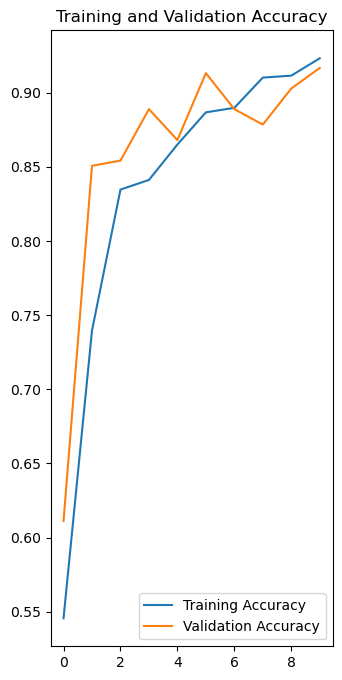

In [25]:
plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(range(EPOCHS), acc, label='Training Accuracy')
plt.plot(range(EPOCHS), val_acc, label= 'Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

First image to predict
First image's actual label: Real
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step
Predicted label: Real


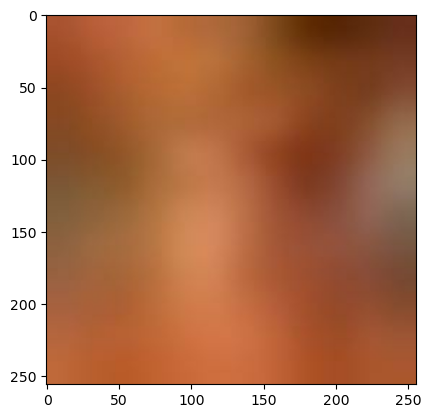

In [26]:
for images_batch, labels_batch in test_ds.take(1):

    first_image = images_batch[0].numpy().astype('uint8')
    first_label = labels_batch[0].numpy()

    print("First image to predict")
    plt.imshow(first_image)
    print("First image's actual label:", class_names[first_label])

    batch_prediction = model.predict(images_batch)
    print("Predicted label:", class_names[np.argmax(batch_prediction[0])])

In [27]:
def predict(model, img, class_names):
    img_array = tf.keras.preprocessing.image.img_to_array(img.numpy())
    img_array = tf.expand_dims(img_array, 0)  # Expand dimensions for batch

    predictions = model.predict(img_array)
    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * np.max(predictions[0]), 2)
    
    return predicted_class, confidence


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step


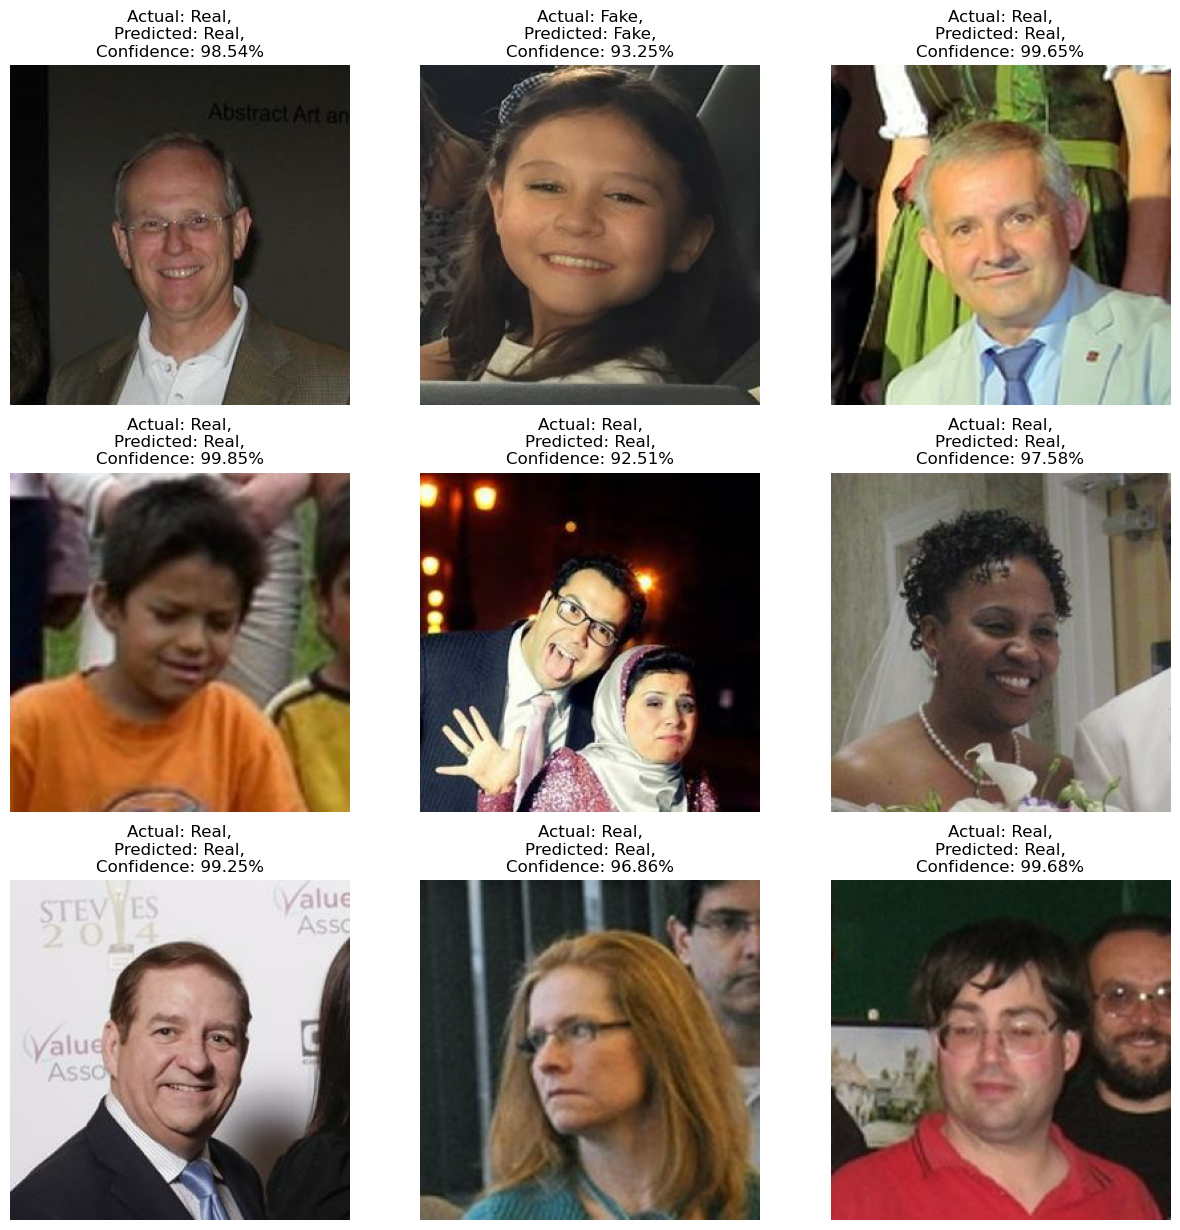

In [28]:
plt.figure(figsize=(15, 15))
for images, labels in test_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        
        predicted_class, confidence = predict(model, images[i], class_names)
        actual_class = class_names[labels[i]] 
        
        plt.title(f"Actual: {actual_class},\nPredicted: {predicted_class},\nConfidence: {confidence}%")
        plt.axis("off")
